<h1 align="left">Helpfulness Prediction of Amazon Product Reviews</h1> 
<h2 align="left">DS Workshop - Fall 18/19 - Tel Aviv University</h2> 
<h3 align="left">By Daniel K.A, Ido Salomon, Itamar Mutzafi and Sagi Aharoni</h3> 




#Notebook Initialization
This section should only run once on a new runtime

In [1]:
#@title Install Required Packages

!pip install wordcloud
!pip install nltk
!pip install textstat
!pip install pyspellchecker
!pip install requests
!pip install tqdm
!pip install clint
!pip install mlxtend

  Stored in directory: /root/.cache/pip/wheels/4f/e9/45/223565e5b1a4b09e12c6de6f8ba7c2c0e9127dec17cf830f83
  Stored in directory: /root/.cache/pip/wheels/58/54/ea/d995d18af68c057eb76b87b02c92bc66ac34d360ef141780f4
Successfully built clint args


In [2]:
#@title Import Python Libraries {display-mode: "form"}
import random
import os
import glob
import pandas as pd
import csv
import json
import datetime
from contextlib import contextmanager
from os.path import getsize, basename
import requests
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import gzip
from google.colab import files
from google.colab import drive
import dill as pickle
import textstat
import math
from __future__ import print_function
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
from textblob import TextBlob
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import tokenize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import nltk
import string
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import minmax_scale
from spellchecker import SpellChecker
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
import gc
from clint.textui import progress
from tqdm import tqdm_notebook as tqdm
import requests
import time
from sklearn.preprocessing import PowerTransformer
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import f_classif


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

spell = SpellChecker()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#@title Choose Data Source {display-mode: "form"}

root = "drive/Team Drives/DS Workshop/"
TEST_SET_PICKLE = "Test_Set"
QUICKSAVE_PICKLE = "Quicksave"

PICKLE_TYPES = [TEST_SET_PICKLE, QUICKSAVE_PICKLE]

data_source = 'Google Drive' #@param ["Google Drive", "Local"]
load_non_neutral_datasets = True #@param {type:"boolean"} 
loaded_from_pickle = False

if (data_source == 'Google Drive'):
    # Connect to drive.
    drive.mount('/content/drive/')
elif data_source == 'Local':
    root = "./"
    
# make pickle_types directories
for pickle_type in PICKLE_TYPES:
    path = root + pickle_type
    if not os.path.exists(path):
      os.mkdir(path)

data_folder = root
if load_non_neutral_datasets:
    data_folder += "data_no_neutral/"
else:
    data_folder += "data/"

def pickleRead(pickle_type, filename):
    data_f = open(root + pickle_type + ("/%s.pickle" % filename), "rb")
    data = pickle.load(data_f)
    data_f.close()
    return data

def pickleWrite(pickle_type, variable, filename):
    saveData = open(root + pickle_type + ("/%s.pickle" % filename), "wb")
    pickle.dump(variable, saveData)
    saveData.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Local DB Fetching

In [0]:
def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()
  headers = {'Range':'bytes=0-'}
  response = session.get(URL,headers=headers, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)

  if token:
      params = { 'id' : id, 'confirm' : token }
      response = session.get(URL,headers=headers, params = params, stream = True)

  save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    rng = response.headers.get('Content-Range')
    cont_leng=int(rng.partition('/')[-1])
    pbar = tqdm(
        total=cont_leng, 
        unit='B', unit_scale=True, desc=destination)
    #assert 0 == 1
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                pbar.update(CHUNK_SIZE)
                
FILE_DB_ID = 0
FILE_DB_EXISTANCE = 1

FILE_DB_ORIG = "file_db"
FILE_DB_NO_NEUTRALS = "file_db_no_neutrals"

init_file_db_original = {
                "Apparel.tsv" : ("15J2qWrfixNZtuKP_rythZcdZ7jMBgJma", False),
                "Watches.tsv" : ("15Uorj0owdJrEeM1-EQgBeIv_jFHJUAw_", False),
                "Beauty.tsv" : ("150TLBOBgaSJeDXQ1YGIRb3meKGDBei20", False),
                "Baby.tsv" : ("152OE8vEvSe050QfyThf4pZXNtjV2Hb49", False),
                "Automotive.tsv" : ("15CJFjDB0g3bmg4xRWu7M4RPTSNB0Wdhu", False),
                "Books_v1_00.tsv" : ("14wLw92wpbeg1o50MDyQKGz_o-kHxBY9n", False),
                "Digital_Software.tsv" : ("14arSG9tVjhQq78mIOfctl4xo-lV1R-Df", False),
                "Digital_Music_Purchase.tsv" : ("14fNXNqT6xrvGNBzyNuBsPEMJ3Nvpl5cK", False),
                "Digital_Ebook_Purchase1.tsv" : ("14lWd7SfLLF7x4b91HXxG_9N3A8Oq305W", False),
                "Camera.tsv" : ("14lf-vbGN6WrCjOg-cQHF-qfqixlin44h", False),
                "Books.tsv" : ("14nY9vnmgr4a4UySg1yxdPD2zJfmxvfUP", False),
                "Digital_Ebook_Purchase.tsv" : ("14uKr9RzhV4rBUbMwSW4mF_5JGzdoq0en", False),
                "Books_v1_01.tsv" : ("14vp1Jt8-Z512T3JQ0ipUY0o_xsEkGKvD", False),
                "Health_Personal_Care.tsv" : ("13nj0saFtD1ZwQ93hU0simTJZ3tI7Knx5", False),
                "Grocery.tsv" : ("13qlyWRZ0MuGZaRSakQ3GfPh3AQTHwHqK", False),
                "Gift_Card.tsv" : ("13xvYHdHOpjbdAP4K5MHdmg9zQn2nbXj0", False),
                "Furniture.tsv" : ("144Wts_J9_PrWCeiQCp6WP-ESsbEPrj53", False),
                "Electronics.tsv" : ("1464Te5hMOaU5ZgqPtsyaFTebjdIJleVZ", False),
                "Digital_Video_Download.tsv" : ("14Vi6UYmHsrO6ydvqXLkUfV_x1k7oLQ_T", False),
                "Mobile_Apps.tsv" : ("13AQ3G65NYfrunooRGHFdvXQMB6AsNTLy", False),
                "Major_Appliances.tsv" : ("13PH1aq_dhoEPGfTs5eMbypvaP9E_yCyW", False),
                "Luggage.tsv" : ("13Y7lwdOtvYdvkP7Qpjwf3RusIwBTnP1B", False),
                "Lawn_and_Garden.tsv" : ("13ZtVB_ORCxrt9WBT5E1m8d0TFgfoylMT", False),
                "Kitchen.tsv" : ("13ipSTsOu-OFkavz5z7hONJrpojd5gk2F", False),
                "Jewelry.tsv" : ("13kC_eK-UavQlMoqtMu31M6dIB_-wNfzS", False),
                "Home_Improvement.tsv" : ("13l4eBvnbF9qZjTJBZOKhXe5n2XUhyevP", False),
                "Home_Entertainment.tsv" : ("13lZkUkrzNoJDL1G8GhC41MEFpdw0vCe8", False),
                "Home.tsv" : ("13mokMehSe4-V3cMDDc9D5fgK--dO-9dh", False),
                "Personal_Care_Appliances.tsv" : ("12qT3fZN7yGdtwl2d3iu-45cZ9VphhuwN", False),
                "PC.tsv" : ("12qtRsF0nidSK8D8QGEbRCSFZt19VJY_t", False),
                "Outdoors.tsv" : ("12tt2ShYdeer3T3wwu4L-8dz2P09em8pG", False),
                "Office_Products.tsv" : ("1309gBj2VUQ_AcF9LTG398NpduxRV0TwY", False),
                "Musical_Instruments.tsv" : ("130xSLM06hQoScqe8DinMwY-GV98oDljm", False),
                "Music.tsv" : ("134aIeU5qeld2kax1ZiBvPjEh1e3EjgtY", False),
                "Mobile_Electronics.tsv" : ("136CCh7Ux2VRkykqg9JvmrsolCFwqDgwe", False),
                "Video.tsv" : ("12ZcuCAGoqW-sbMY10pWZxKPj5kwrgtaj", False),
                "Toys.tsv" : ("12_yv9wq-cr_y9RJBGR2gFrpc7Zmz3VdS", False),
                "Tools.tsv" : ("12fZijUQFu3Ce-pA5piOBUYOqXUikkyEx", False),
                "Sports.tsv" : ("12gm91nEibXS-GkFoQo9Q5uoA6GpatqPO", False),
                "Software.tsv" : ("12i932su0Ofda7kMtZcfT-BXpLo4tk1vO", False),
                "Shoes.tsv" : ("12iKvxbhyi2yNqETHs-CdI0z3uX4s8P4T", False),
                "Pet_Products.tsv" : ("12qKBaGhFv9hKti4PAwDqQVCTfVbkUvdE", False),
                "Wireless.tsv" : ("1-6_fpo5NKoqHPXt5_6NJwTFX3i0-qrEy", False),
                "Video_Games.tsv" : ("1-82C-cpVxRIh1RSg-o62TYQkjWpAB6y-", False),
                "Digital_Video_Games.tsv" : ("1-8LKqrsJIzE0A0_dq8fYVLTcAoVZwTLA", False),
                "Video_DVD.tsv" : ("12TTXWbRFjkEAbZI81c3zkGd8bxC0Jfkf", False),
               }

init_file_db_no_neutrals = {
              "Apparel.tsv" : ("1-4TmWinZ4tHN5L9RLisCb1P3nrZ-ypAH", False),
              "Automotive.tsv" : ("1-5WYYYcDzsbpevpTEbo5wi4ah-jNJAZ6", False),
              "Baby.tsv" : ("1-D3NiXVK4JPLCvhLAM_UKzl0wxlEN_Z-", False),
              "Beauty.tsv" : ("1-FjxxpbwQT1VS4XHHeirfmtvoDpVsT09", False),
              "Books.tsv" : ("1q4YTPc92TH61N84IptA5jmo9d6VG2nC7", False),
              "Books_v1_00.tsv" : ("1jaG36ny5Yxa3qrgd0ELaK9KZw3OWeI-g", False),
              "Books_v1_01.tsv" : ("1I01c0IHrGN3HiuIoSAmjWn888fkow_pL", False),
              "Camera.tsv" : ("1-0bOjYAlc6a-UdTOS9fKAFdd0SvtF9_b", False),
              "Digital_Ebook_Purchase.tsv" : ("1-EqJBx11bUWydi14ro1SMpyUTdVMpXV2", False),
              "Digital_Ebook_Purchase1.tsv" : ("1in9tdxTNi2sYsuKH6Ve95R_R2SKznDFr", False),
              "Digital_Music_Purchase.tsv" : ("1--STpm2s2ryN4AgS3xlgyg7aRWyCkcjj", False),
              "Digital_Software.tsv" : ("1-4E8wJmPIWr7umopiVzoo5krQElNWxg3", False),
              "Digital_Video_Download.tsv" : ("1-5RLlE1gq-KOMI2YJmmrshkODQZSVcu3", False),
              "Digital_Video_Games.tsv" : ("1-6Cxfg-i0mjfLwjw57g8E6CmYxjtMvgn", False),
              "Electronics.tsv" : ("1-EJE-2bHcBwJ8qe10WtliFUsDWJOO6k6", False),
              "Furniture.tsv" : ("1-F3VGgr6OmgQjwx5fF9mBxZMEEKCiNby", False),
              "Gift_Card.tsv" : ("1-QDp7q3MAlE3bH2bh9O7TNN9tAgDHXt0", False),
              "Grocery.tsv" : ("1-R0XjkTXsF0q_6hUz1jCJtIEaMqrMsqW", False),
              "Health_Personal_Care.tsv" : ("1-TdLr00rb33npHZSr6Ylz-QUFS0k9amP", False),
              "Home.tsv" : ("1-UjWOBS_RmoA6rdo_3WbIJjNzAI2xUY1", False),
              "Home_Entertainment.tsv" : ("1-XCM3NWvWPGqLiNyWO3Ew9XxBkFfllCH", False),
              "Home_Improvement.tsv" : ("1-j13y-cFZ0lbEWmmTo9PIGgocqd8p3Mu", False),
              "Jewelry.tsv" : ("1-m9KkUCNQj2NohMc9sEDfKha-TYrHdWu", False),
              "Kitchen.tsv" : ("1-xUeXkAYCs7uT3PskwQZustMXLElolcE", False),
              "Lawn_and_Garden.tsv" : ("1-yQtwhBoTrm3bvNQ3LYvCAYwVW7wVtjB", False),
              "Luggage.tsv" : ("103mrM6BggbXtkOD0w_HvJ4CrHXqXPtkD", False),
              "Major_Appliances.tsv" : ("107CuhJa2UJeLYwe-ZR4KSe8lHDNO0AWY", False),
              "Mobile_Apps.tsv" : ("10Dike2qTaSp8TW2KsmZgsFrhjyStTGd-", False),
              "Mobile_Electronics.tsv" : ("10RaCEohA48HO0eKgDJE1L8pvn6ovwdKt", False),
              "Music.tsv" : ("10_MRpd8YfA6GJ1s6ABam43UmjQrYuclO", False),
              "Musical_Instruments.tsv" : ("10qp5c9A0CjNFtwiRzUnLfHBDtVjLGRFw", False),
              "Office_Products.tsv" : ("10ry-Tlt96GJeDUpTXIKT0EkU0gaAMz3L", False),
              "Outdoors.tsv" : ("10wXs21GRai_cdvCuEn1t81mAkkGfaqF6", False),
              "PC.tsv" : ("1104aR_2BeMMEaZSSGU7X_KysOREKR5AF", False),
              "Personal_Care_Appliances.tsv" : ("110FE0Td1RmnXwRSiWh-KD4EnsE5xgSvQ", False),
              "Pet_Products.tsv" : ("110Lx6y9ZVAjV0K5msVpFKLFtCVmZCHlm", False),
              "Shoes.tsv" : ("111NsKKmd211BX1OZAqIiLL-kH7U1PkxG", False),
              "Software.tsv" : ("115I2QAXROLomQ03yaLWgcLmVqxeBmyXW", False),
              "Sports.tsv" : ("11CfJfGFLEbvlCOBwAw6PnTcOU9LV4rou", False),
              "Tools.tsv" : ("11F6Ui-8VoXY6OD2FMnWZwJa2SjBAtdLu", False),
              "Toys.tsv" : ("11ITxlXQH2TguO87vDAAo6V0T3WBzKNKE", False),
              "Video.tsv" : ("11JH6KMNA3efFcAPkF9-x49CBj7MPNXIo", False),
              "Video_DVD.tsv" : ("11Mtp3vyG32xO_5cpbJjLutF-jtGkAYaw", False),
              "Video_Games.tsv" : ("11SZVW1IIuhJFCVaLwnAwnDuvavGqUHXD", False),
              "Watches.tsv" : ("11SwuJa4ba8Ppa982IRq0-36ySez4j6Ib", False),
              "Wireless.tsv" : ("11U8z7PQXFIuKVXI0Tr7vl8SEM4lLEdTy", False),
               }

if load_non_neutral_datasets:
  file_db_type = FILE_DB_NO_NEUTRALS
  init_file_db = init_file_db_no_neutrals
else:
  file_db_type = FILE_DB_ORIG
  init_file_db = init_file_db_original
  
if data_source == "Standalone": 
  try:
    # load file db for knowing which data files were already fetched
    file_db = pickle.load(open(root + file_db_type, "rb"))
    print('loaded pickle')
  except:
    # on first run - create new file db with all files marked as unavailalbe locally
    file_db = init_file_db
  for filename in file_db:
    if file_db[filename][FILE_DB_EXISTANCE] == False:
      # file not available locally - download from Google Driveå
      try: 
        print("downloading", filename)
        download_file_from_google_drive(file_db[filename][FILE_DB_ID], 
                                        root + data_folder + "/" + filename)
        file_db[filename][FILE_DB_EXISTANCE] = True
      except:
        print("failed downloading", filename)
  pickle.dump(file_db, open(root + file_db_type, "wb"))

In [0]:
#@title Infra Definitions

@contextmanager
def pbopen(filename, mode='r'):
    total = getsize(filename)
    pb = tqdm(total=total, unit="B", unit_scale=True,
              desc=basename(filename), miniters=1,
              ncols=80, ascii=True)

    def wrapped_line_iterator(fd):
        processed_bytes = 0
        for line in fd:
            processed_bytes += len(line)
            # update progress every MB.
            if processed_bytes >= 1024 * 1024:
                pb.update(processed_bytes)
                processed_bytes = 0

            yield line

        # finally
        pb.update(processed_bytes)
        pb.close()

    with open(filename, mode) as fd:
        yield wrapped_line_iterator(fd)
        
#decompress input folder to output folder
def ungzip(source_dir, dest_dir):
  for src_name in glob.glob(os.path.join(source_dir, '*.gz')):
      base = os.path.basename(src_name)
      dest_name = os.path.join(dest_dir, base[:-3])
      with gzip.open(src_name, 'rb') as infile:
          with open(dest_name, 'wb') as outfile:
              for line in infile:
                  outfile.write(line)

# Data Collection and Integration


In [6]:
#@markdown ###Check for available downloads

root = "drive/Team Drives/DS Workshop/"
root_no_neutral = "drive/Team Drives/DS Workshop/data_no_neutral/"
file_ext = ".tsv"
file_names_all = sorted(glob.glob1(root, "*" + file_ext))
#print(file_names_all)

file_names_have = sorted(glob.glob1(root_no_neutral, "*" + file_ext))

file_names = [f for f in file_names_all if f not in file_names_have]

if (file_names==[]):
  print("All files were downloaded already!")
else:
  print("Available for download:")
  print(file_names)

All files were downloaded already!


In [0]:
# Calculate the size for each category.
#@markdown ###Use precalculated sizes?
use_precalculated_sizes = True #@param {type:"boolean"}

if use_precalculated_sizes:
  if load_non_neutral_datasets:
    file_sizes = {
      'Apparel.tsv' : 230221,
      'Automotive.tsv' : 153099,
      'Baby.tsv' : 107685,
      'Beauty.tsv' : 349724,
      'Books.tsv' : 1418511,
      'Books_v1_00.tsv' : 630435,
      'Books_v1_01.tsv' : 1495443,
      'Camera.tsv' : 191541,
      'Digital_Ebook_Purchase.tsv' : 360498,
      'Digital_Ebook_Purchase1.tsv' : 374650,
      'Digital_Music_Purchase.tsv' : 36312,
      'Digital_Software.tsv' : 8610,
      'Digital_Video_Download.tsv' : 74872,
      'Digital_Video_Games.tsv' : 9575,
      'Electronics.tsv' : 211890,
      'Furniture.tsv' : 80027,
      'Gift_Card.tsv' : 882,
      'Grocery.tsv' : 158741,
      'Health_Personal_Care.tsv' : 491054,
      'Home.tsv' : 413825,
      'Home_Entertainment.tsv' : 90273,
      'Home_Improvement.tsv' : 183164,
      'Jewelry.tsv' : 64333,
      'Kitchen.tsv' : 396753,
      'Lawn_and_Garden.tsv' : 219379,
      'Luggage.tsv' : 28784,
      'Major_Appliances.tsv' : 18321,
      'Mobile_Apps.tsv' : 381737,
      'Mobile_Electronics.tsv' : 5976,
      'Music.tsv' : 741615,
      'Musical_Instruments.tsv' : 77019,
      'Office_Products.tsv' : 187336,
      'Outdoors.tsv' : 175754,
      'PC.tsv' : 348331,
      'Personal_Care_Appliances.tsv' : 11981,
      'Pet_Products.tsv' : 165006,
      'Shoes.tsv' : 161524,
      'Software.tsv' : 68214,
      'Sports.tsv' : 296677,
      'Tools.tsv' : 140003,
      'Toys.tsv' : 307859,
      'Video.tsv' : 100447,
      'Video_DVD.tsv' : 696093,
      'Video_Games.tsv' : 181240,
      'Watches.tsv' : 52999,
      'Wireless.tsv' : 288635
    }
  else:
    file_sizes = {
        'Apparel.tsv': 5906333, 
        'Automotive.tsv': 3514942,
        'Baby.tsv': 1752932,
        'Beauty.tsv': 5115666,
        'Books.tsv': 3105520, 
        'Books_v1_00.tsv': 10319090, 
        'Books_v1_01.tsv': 6106719, 
        'Camera.tsv': 1801974,
        'Digital_Ebook_Purchase.tsv': 5101693,
        'Digital_Ebook_Purchase1.tsv': 12520722,
        'Digital_Music_Purchase.tsv': 1688884, 
        'Digital_Software.tsv': 102084,
        'Digital_Video_Download.tsv': 4057147,
        'Digital_Video_Games.tsv': 145431,
        'Electronics.tsv': 3093869,
        'Furniture.tsv': 792113,
        'Gift_Card.tsv': 149086, 
        'Grocery.tsv': 2402458, 
        'Health_Personal_Care.tsv': 5331449, 
        'Home.tsv': 6221559,
        'Home_Entertainment.tsv': 705889,
        'Home_Improvement.tsv': 2634781,
        'Jewelry.tsv': 1767753,
        'Kitchen.tsv': 4880466,
        'Lawn_and_Garden.tsv': 2557288,
        'Luggage.tsv': 348657,
        'Major_Appliances.tsv': 96901, 
        'Mobile_Apps.tsv': 5033376, 
        'Mobile_Electronics.tsv': 104975, 
        'Music.tsv': 4751577, 
        'Musical_Instruments.tsv': 904765,
        'Office_Products.tsv': 2642434,
        'Outdoors.tsv': 2302401,
        'PC.tsv': 6908554,
        'Personal_Care_Appliances.tsv': 85981,
        'Pet_Products.tsv': 2643619, 
        'Shoes.tsv': 4366916,
        'Software.tsv': 341931,
        'Sports.tsv': 4850360,
        'Tools.tsv': 1741100,
        'Toys.tsv': 4864249,
        'Video.tsv': 380604,
        'Video_DVD.tsv': 5069140,
        'Video_Games.tsv': 1785997, 
        'Watches.tsv': 960872, 
        'Wireless.tsv': 9002021
      }
else:
  file_names = sorted(glob.glob1(data_folder, "*" + file_ext))
  file_sizes = {}
  print(file_names)
  for filename in file_names:
    num_lines = sum(1 for line in open(data_folder + filename))
    file_sizes[filename] = num_lines
    print(filename,str(num_lines))
    gc.collect()

##Load Data

In [0]:
#@markdown ###Data Loading
pick_category = "Music"  #@param ['All Categories', 'Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Books_v1_00', 'Books_v1_01', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Ebook_Purchase1', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift_Card', 'Grocery', 'Health_Personal_Care', 'Home', 'Home_Entertainment', 'Home_Improvement', 'Jewelry', 'Kitchen', 'Lawn_and_Garden', 'Luggage', 'Major_Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical_Instruments', 'Office_Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet_Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video_DVD', 'Video_Games', 'Watches', 'Wireless']
entry_limit = 700000  #@param {type: "slider", min: 1000, max: 1000000, step:1000}
read_random_entries = True #@param {type:"boolean"}

include_all_categories = pick_category == "All Categories"

if not include_all_categories:
  available_in_cat = file_sizes[pick_category + file_ext]
  if (entry_limit > available_in_cat):
    print("The requested category doesn't have enough entries.",
          "\nTherefore, entry limit was changed to %d." % available_in_cat)
    entry_limit = available_in_cat


In [9]:
if include_all_categories:
  selected_paths = file_names
else:
  selected_paths = [pick_category + file_ext]
  
ds_list = []

if (not loaded_from_pickle):
  if (data_source == 'Google Drive'):
    read_per_part = entry_limit//len(selected_paths)
    for filename in selected_paths:
      print('Loading:', filename, '\n')
      if read_random_entries:
        numReviewsInCategory = max(file_sizes[filename]-1, 0)
        is_last_file = filename == selected_paths[-1]
        if is_last_file:
          num_rows_read = entry_limit-len(ds_list)*read_per_part
        else:
          num_rows_read = read_per_part
        skip = sorted(random.sample(range(1, numReviewsInCategory), numReviewsInCategory - min(numReviewsInCategory, num_rows_read)))
      else:
        skip = []
      cat_ds = pd.read_csv(data_folder+filename, 
                          delimiter='\t',
                          warn_bad_lines=True,
                          error_bad_lines=False,
                          skiprows = skip,
                          quoting=csv.QUOTE_NONE,
                          encoding="utf8")
      ds_list.append(cat_ds)
    reviews = pd.concat(ds_list, axis = 0, ignore_index = True)
  elif (data_source == 'Local Files'):
    reviews = pd.read_csv(data_folder+filename, 
                          encoding="utf8",
                          delimiter='\t',
                          warn_bad_lines=True,
                          error_bad_lines=False,
                          quoting=csv.QUOTE_NONE,
                          nrows=entry_limit)

Loading: Music.tsv 



##Data Overview

In [10]:
if (not loaded_from_pickle):
  print('Number of reviews:',reviews.shape[0])
  print('Description:')
  print(reviews.describe())
  print('Data types: \n')
  print(reviews.dtypes)
  display(reviews.head())
  display(reviews.tail())

Number of reviews: 700000
Description:
        customer_id  product_parent    star_rating  helpful_votes  \
count  7.000000e+05    7.000000e+05  700000.000000  700000.000000   
mean   4.000768e+07    5.003523e+08       4.245150      11.960341   
std    1.313413e+07    2.872570e+08       1.244058      16.630803   
min    1.009900e+04    1.055600e+04       1.000000       5.000000   
25%    3.110795e+07    2.514353e+08       4.000000       6.000000   
50%    4.539801e+07    5.006496e+08       5.000000       8.000000   
75%    5.095530e+07    7.489060e+08       5.000000      12.000000   
max    5.309658e+07    9.999993e+08       5.000000    2181.000000   

         total_votes  
count  700000.000000  
mean       14.734434  
std        19.079034  
min         5.000000  
25%         7.000000  
50%        10.000000  
75%        16.000000  
max      2246.000000  
Data types: 

marketplace          object
customer_id           int64
review_id            object
product_id           object
produc

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,52890295,R3C2J53J8UDDPW,B00J3FHZ38,317827037,Jeroen Van Veen: Piano Music,Music,5,5,5,N,N,Lots of surprises in 5 discs of wonderful comp...,You’d be hard pressed to think of anyone who’s...,2015-08-31
1,US,19900921,RAERVMB5F7O47,B00TEJB8JK,18685663,Sound & Color,Music,3,6,8,N,Y,Good but certainly not great,"This album is okay, but not great.<br />The so...",2015-08-31
2,US,23282003,R2SHXRL6SL1GC9,B010FP0WRU,974013859,#392: The EP Collection,Music,3,25,26,N,Y,Up it by a half-star if you put it on shuffle ...,A solid collection of tracks assembled from a ...,2015-08-31
3,US,31666533,R2WYFCOSRGRZXF,B00ZGJ85Y8,547995808,War Room (Music from and Inspired by the Origi...,Music,5,14,15,N,Y,Awesome Soundtrack,"Yes, I love every single son on this CD and th...",2015-08-31
4,US,14951691,R3VBSR7GZS50CU,B00L76LQ0O,73651700,Made In Detroit,Music,5,6,6,N,N,CD is great.,I would like to give some perspective regardin...,2015-08-31


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
699995,US,52954509,RN9MW1HCCFSRY,B0000006U6,802364043,The Art Of The Theremin,Music,5,6,8,N,N,Superb Disc,The theremin was invented by Leon Theremin in ...,1997-04-19
699996,US,53076152,R1SRIGSUBITNAR,B000002SM0,535270986,The Complete Recording of Boublil & Schonberg'...,Music,3,15,17,N,N,Disappointing follow-up to Original London Cas...,"Featuring new, never before recorded segments ...",1997-03-10
699997,US,53060959,R3DVJI5Z2BPWS3,0964349604,710278392,Fair Use : The Story of the Letter U & the Num...,Music,4,6,6,N,N,An unusual book on the legal concept of &quot;...,These days many artists and writers are inter...,1997-01-24
699998,US,53065285,RCCO7QP25QFYU,B0000032CU,734573994,The Vogues - Greatest Hits,Music,5,30,31,N,N,Excellent! Melodic; superb vocal harmonies! A ...,The Vogues are a band that I recently rediscov...,1996-12-20
699999,US,53058447,R2K6VMIL048HD3,B0000000K4,126873550,Passages,Music,5,6,7,N,N,The upmost delightful sound collection you can...,The collaboration between the indian musician ...,1996-10-18


#Data Preperation and Cleaning

In [11]:
print("There are %d reviews." % len(reviews))
#Cleanup in review text: <br>,<br/>,&#34;, [[...]]
reviews['review_body'] = reviews['review_body'].replace('\[\[.*\]\]|<.*br.*>',' ',regex=True)
reviews['review_body'] = reviews['review_body'].replace('&#34;|[^\x00-\x7F]+','',regex=True)
reviews['review_body'] = reviews['review_body'].apply(lambda text:str(text).strip())
reviews = reviews.dropna()
print("Cleared rows with NaN values, %d reviews left." % len(reviews))
reviews = reviews[reviews['review_body'].apply(lambda x : len(str(x))) > 3]
print("Cleared rows with very short (or empty) texts, %d reviews left." % len(reviews))
reviews = reviews.drop_duplicates(subset = ['customer_id','review_headline','review_body'] )
print("After drop_duplicates there are %d reviews." % len(reviews))


There are 700000 reviews.
Cleared rows with NaN values, 699972 reviews left.
Cleared rows with very short (or empty) texts, 699595 reviews left.
After drop_duplicates there are 698432 reviews.


#Data Visualization and Analysis

# Feature Selection and Engineering

In [12]:
reviews.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,6.984320e+05,6.984320e+05,698432.000000,698432.000000,698432.000000
mean,4.001044e+07,5.003551e+08,4.245584,11.953805,14.726494
std,1.313355e+07,2.872464e+08,1.243453,16.596287,19.046068
min,1.009900e+04,1.055600e+04,1.000000,5.000000,5.000000
25%,3.110962e+07,2.514451e+08,4.000000,6.000000,7.000000
50%,4.540531e+07,5.006640e+08,5.000000,8.000000,10.000000
75%,5.095567e+07,7.488687e+08,5.000000,12.000000,16.000000
max,5.309658e+07,9.999993e+08,5.000000,2181.000000,2246.000000


In [0]:
def add_meta_features(dataset):
  dataset['helpful'] = ApplyHelpfulnessVector(dataset) 
  
def ApplyHelpfulnessVector(reviews):
  return reviews.apply(lambda row: isHelpful(row['total_votes'], row['helpful_votes']), axis=1)

def isHelpful(total_votes, helpful_votes):
  if   (total_votes >= 5 and helpful_votes >= (total_votes * 0.6)):
    return 1
  elif (total_votes >= 5 and helpful_votes <  (total_votes * 0.6)):
    return -1
  else:
    return 0
    
if (not loaded_from_pickle):
  add_meta_features(reviews)
  # Add no. of helpful comments for each reviewer,total_helpful_votes_for_user,total_votes_for_user,reviewer_avg_rating, no. of helpful comments (that pass the threshold) for each reviewer
  commentCount=pd.DataFrame(reviews.groupby('customer_id').size())
  commentCount.columns=['commentCount']

  

In [0]:
reviews = reviews.set_index('customer_id').join(commentCount)
reviews = reviews.reset_index(drop=False) #drop=False to keep customer_id column.
reviews['commentCount'] = reviews['commentCount'] - 1 #comment history should not include current comment
helpfulRatingPerUser = pd.DataFrame(reviews.groupby('customer_id').sum())
helpfulRatingPerUser = helpfulRatingPerUser.drop(columns=['product_parent','star_rating','commentCount'])
helpfulRatingPerUser.columns=['total_helpful_votes_for_user','total_votes_for_user','userHelpfulness']
reviews = reviews.join(helpfulRatingPerUser, on='customer_id')
reviews['userHelpfulness'] = reviews['userHelpfulness'] - reviews['helpful']
reviews['total_helpful_votes_for_user'] = reviews['total_helpful_votes_for_user'] - reviews['helpful_votes']
reviews['total_votes_for_user'] = reviews['total_votes_for_user'] - reviews['total_votes']
reviews['reviewer_avg_rating'] = reviews['total_helpful_votes_for_user']/reviews['total_votes_for_user']
reviews['reviewer_avg_rating'] = reviews['reviewer_avg_rating'].fillna(0)


In [15]:
#@markdown ###Review Filters
def isBiggerDate(date1, date2):
  year1,month1,day1 = [int(x) for x in date1.split('-')]
  year2,month2,day2 = [int(x) for x in date2.split('-')]
  ydiff,mdiff,ddiff = year1-year2,month1-month2,day1-day2
  if (ydiff>0): return True;
  elif (ydiff<0): return False;
  if (mdiff>0): return True;
  elif (mdiff<0): return False;
  if (ddiff>0): return True;
  elif (ddiff<0): return False;
  return False

def get_set_info(subset):
  return { 'helpful': np.sum(subset['helpful']== 1),
           'neutral': np.sum(subset['helpful']== 0),
           'unhelpful': np.sum(subset['helpful']== -1) }

def print_set_info(name, set_info):
  print(name, 'set size:', sum(set_info.values()))
  print('* Helpful:', set_info['helpful'])
  print('* Neutral:', set_info['neutral'])
  print('* Unhelpful:', set_info['unhelpful'])
  print('** Total helpful + unhelpful:', set_info['helpful']+set_info['unhelpful'],'\n')
  
train_min_date = '2000-01-01'  #@param {type: "date"}
train_max_date = '2013-12-31'  #@param {type: "date"}
test_min_date = '2014-01-01'  #@param {type: "date"}
override_test_set = False       #@param {type: "boolean"}

if not (isBiggerDate(train_max_date,train_min_date)):
  assert False, 'Error: train_max_date must be bigger than train_min_date.\nPlease fix your dates selection.'
if not (isBiggerDate(test_min_date,train_max_date)):
  assert False, 'Error: test_min_date must be bigger than train_max_date.\nPlease fix your dates selection.'

# add columns to mark reviews which are part of the test/validation test  
if 'isTestSet' in reviews.columns:
  reviews = reviews.drop(['isTestSet'], axis=1)
reviews.insert(0, 'isTestSet', False)

train_set = reviews[(reviews['review_date'] > train_min_date) & (reviews['review_date'] < train_max_date)]

# test set should be constant (only created once in the project lifetime)
if (override_test_set) or (os.path.exists(root + TEST_SET_PICKLE + "/" + pick_category) == False):
    print('Generating test set for the first time in the ds workflow lifetime!')
    test_set  = reviews[reviews['review_date'] > test_min_date] # test set + validation
     # mark examples used in test set
    if 'isTestSet' in reviews.columns:
      reviews = reviews.drop(['isTestSet'], axis=1)
    reviews.insert(0, 'isTestSet', True)
    pickleWrite(TEST_SET_PICKLE, test_set, pick_category)
else:
    print('Loading existing test set for category %s' % pick_category)
    test_set = pickleRead(TEST_SET_PICKLE, pick_category)

#test_set  = reviews[reviews['review_date'] > test_min_date]

train_info = get_set_info(train_set)
test_info = get_set_info(test_set)
print_set_info('Train', train_info)
print_set_info('Test', test_info)

Generating test set for the first time in the ds workflow lifetime!
Train set size: 638988
* Helpful: 571497
* Neutral: 0
* Unhelpful: 67491
** Total helpful + unhelpful: 638988 

Test set size: 27040
* Helpful: 24624
* Neutral: 0
* Unhelpful: 2416
** Total helpful + unhelpful: 27040 



## Bias Correction

In [16]:
# Star rating bias correction.

def split_by_helpfulness(subset):
  return (subset[subset['helpful']==1],
          subset[subset['helpful']==-1])

def split_by_star_rating(subset):
  return (subset[subset['star_rating']>=4],
          subset[subset['star_rating']==3],
          subset[subset['star_rating']<=2])

helpful = split_by_helpfulness(train_set)[0]
helpful_reviewlist = list(split_by_star_rating(helpful))
helpful_star_dist = [x.shape[0] for x in helpful_reviewlist]

unhelpful = split_by_helpfulness(train_set)[1]
unhelpful_reviewlist = list(split_by_star_rating(unhelpful))
unhelpful_star_dist = [x.shape[0] for x in unhelpful_reviewlist]

limitingFactor = min(helpful_star_dist+unhelpful_star_dist)
print("[TRAIN SET] model input (unbiased reviews):", limitingFactor*6, 'reviews.')

train_set_sampled = pd.DataFrame()

sample_classes = helpful_reviewlist + unhelpful_reviewlist
for sample_class in sample_classes:
  df_tmp = sample_class.sample(n=limitingFactor)
  train_set_sampled = pd.concat([train_set_sampled, df_tmp])
  
#train_set_sampled['star_rating'].plot.hist(bins=5)

test_set_percentage = 0.3  #@param {type:"slider", min: 0.25, max: 0.45, step:0.025}
test_set_size = round(test_set_percentage*train_set_sampled.shape[0]/(1-test_set_percentage))
print("[TEST SET] model input (biased reviews):", test_set_size)

#print('Removing neutral reviews from the test set.')
test_set_sampled = test_set[test_set['helpful'] != 0] # remove neutral reviews from test set
test_set_sampled = test_set_sampled.sample(test_set_size)
# Test and Train data can be extracted from unbiased_reviews using the date information.
unbiased_reviews = pd.concat([train_set_sampled, test_set_sampled])
print("Total data size = unbiased train set reviews + biased test set reviews:", unbiased_reviews.shape[0])


[TRAIN SET] model input (unbiased reviews): 57270 reviews.
[TEST SET] model input (biased reviews): 24544
Total data size = unbiased train set reviews + biased test set reviews: 81814


In [0]:
# #@markdown ###Train-Test Split 
# test_set_size = 20000  #@param {type:"slider", min: 1000, max: 35000, step:1000}
# test_set_percentage = 0.3  #@param {type:"slider", min: 0.25, max: 0.45, step:0.025}
# #@markdown ###Bias Correction
# correct_bias = True #@param {type:"boolean"}

# num_test_no_neutral = test_info['helpful']+test_info['unhelpful']
# if (test_set_size>num_test_no_neutral):
#   assert False, 'Error: There aren\'t enough reviews in the test set.\nPlease reduce test_set_size below '+str(num_test_no_neutral)+'.'

# if correct_bias:
#   train_size_after_correction = 2*min(train_info['helpful'],train_info['unhelpful'])
#   required_train_size = int(test_set_size/test_set_percentage-test_set_size)
#   if (required_train_size>train_size_after_correction):
#     assert False, 'Error: Can\'t correct bias and keep test:train ratio.\nPlease change test_set_percentage or increase test size.'


In [0]:
# if (not loaded_from_pickle):
#   print('Removing neutral reviews from the test set.')
#   test_set = test_set[test_set['helpful'] != 0] # remove neutral reviews from test set
#   test_set = test_set.sample(test_set_size)
#   print("[TEST SET] model input (biased reviews): %d" % (test_set.shape[0]))
  
#   #print_set_info('Train', train_info)
  
#   if correct_bias:
#     #Guaranteed to have enough reviews (see assertion in previous cell).
#     df1 = train_set[train_set['helpful'] == 1].sample(n=required_train_size//2)
#     df2 = train_set[train_set['helpful'] == -1].sample(n=required_train_size//2)
#     unbiased_reviews = pd.concat([df1,df2])
#   else:
#     unbiased_reviews = train_set.sample(n=required_train_size)
    
#   print("[TRAIN SET] model input (unbiased reviews):", unbiased_reviews.shape[0])
  
#   unbiased_reviews = pd.concat([unbiased_reviews, test_set])
#   print("Total data size = unbiased train set reviews + biased test set reviews:", unbiased_reviews.shape[0])

In [18]:
def dateToInt(dateStr):
  year, month, day = dateStr.split('-')
  return 365*int(year)+30*int(month)+int(day)

def numWords(text):
  return len(re.findall("[a-zA-Z_]+", text))

def numSpellingMistakes(text):
  numMistakes = float(len(spell.unknown(text.split())))
  textLen = float(len(text))
  if (textLen<=0): return 0.0
  return numMistakes/textLen

def add_sentiment_statistics(df,column_title):
  split_sentences = []
  for index, row in df.iterrows():
    split_sentences.append(tokenize.sent_tokenize(row[column_title]))
    
  split_sentences = [[TextBlob(sentence).sentiment for sentence in review] for review in split_sentences]

  split_subjectivity = [[a.subjectivity for a in senten] for senten in split_sentences] 
  subjectivity_avg = [np.mean(review) for review in split_subjectivity]
  subjectivity_std = [np.std(review) for review in split_subjectivity]

  split_polarity = [[a.polarity for a in senten] for senten in split_sentences]
  polarity_avg = [np.mean(review) for review in split_polarity]
  polarity_std = [np.std(review) for review in split_polarity]

  df['subjectivity_avg'] = subjectivity_avg
  df['subjectivity_std'] = subjectivity_std
  df['polarity_avg'] = polarity_avg
  df['polarity_std'] = polarity_std
  

unbiased_reviews = unbiased_reviews.drop(['product_parent', 'product_id', 'review_id', 'customer_id', 'marketplace'], axis=1)
unbiased_reviews = unbiased_reviews.reset_index(drop=True)
data = unbiased_reviews

#Add text statistics, including length.
textStatistics = {
    'body_length' : len,
    'body_num_words' : numWords,
    'num_spelling_mistakes' : numSpellingMistakes,
    'flesch_reading_ease' : textstat.flesch_reading_ease,
    'smog_index' : textstat.smog_index,
    'flesch_kincaid_grade' : textstat.flesch_kincaid_grade,
    'coleman_liau_index' : textstat.coleman_liau_index,
    'automated_readability_index' : textstat.automated_readability_index,
    'dale_chall_readability_score' : textstat.dale_chall_readability_score,
    'difficult_words' : textstat.difficult_words,
    'linsear_write_formula' : textstat.linsear_write_formula,
    'gunning_fog' : textstat.gunning_fog,
}
  
for funcName in textStatistics:
  data.insert(0, funcName, 0.0)
  data[funcName] = data['review_body'].apply(lambda x: float(textStatistics[funcName](str(x))))
  print('Added',funcName,'column.')
#Convert the date column to integer.
data.insert(0, 'date_int', 0.0)
data['date_int'] = data['review_date'].apply(lambda x: float(dateToInt(str(x))))
  
add_sentiment_statistics(data,'review_body')

print(list(data.columns.values))


Added body_length column.
Added body_num_words column.
Added num_spelling_mistakes column.
Added flesch_reading_ease column.
Added smog_index column.
Added flesch_kincaid_grade column.
Added coleman_liau_index column.
Added automated_readability_index column.
Added dale_chall_readability_score column.
Added difficult_words column.
Added linsear_write_formula column.
Added gunning_fog column.
['date_int', 'gunning_fog', 'linsear_write_formula', 'difficult_words', 'dale_chall_readability_score', 'automated_readability_index', 'coleman_liau_index', 'flesch_kincaid_grade', 'smog_index', 'flesch_reading_ease', 'num_spelling_mistakes', 'body_num_words', 'body_length', 'isTestSet', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'helpful', 'commentCount', 'total_helpful_votes_for_user', 'total_votes_for_user', 'userHelpfulness', 'reviewer_avg_rating', 'subjectivity_avg', 'subjecti

In [0]:
#@markdown ###It is recommended to save your reviews now.
save_reviews = False #@param {type:"boolean"}
load_reviews = False #@param {type:"boolean"}

if (save_reviews and not load_reviews):
  pickleWrite("pickled_vars", data, "Data_"+pick_category)
  print("Reviews were saved")
  
if (load_reviews and not save_reviews):
  data = pickleRead("pickled_vars", "Data_"+pick_category)
  print("Reviews were loaded")

In [0]:
pickleWrite("pickled_vars", data, "Data_Music_Star_Rating_Balanced_Sagi")

# Model Training

In [0]:
#@markdown ###DL

# # CNN for the IMDB problem
# import numpy as np
# from keras.preprocessing.text import Tokenizer
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM, Convolution1D, Flatten, Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.layers.embeddings import Embedding
# from keras.preprocessing.sequence import pad_sequences
# import re
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import pickle
# from keras.utils import np_utils
# import pandas as pd
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from keras.wrappers.scikit_learn import KerasClassifier


# data = reviews
# data = data.loc[:, ['review_body','helpful']]


# #Convert reviews text to lowercase
# data['text'] = data['review_body'].apply(lambda x: str(x).lower())
# #Remove all charactares appart from a-zA-z0-9 (for instance: punctuation)
# data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# #overallDistribution = data.overall.value_counts().sort_index()
# #print(overallDistribution)

# #Vocabulary size - Most 2000 common words
# #Convert input text to integer sequences
# max_features = 5000
# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(data['text'].values)
# X = tokenizer.texts_to_sequences(data['text'].values)
# #cap the maximum review length at 500 words,
# #truncating reviews longer than that and
# # padding reviews shorter than that with 0 values.
# max_review_length = 500
# X = pad_sequences(X,  maxlen=max_review_length)

# # Using embedding from Keras
# embedding_vector_length = 32
# def baseline_model():
#     # create the model - Machine learning mastery
#     model = Sequential()
#     model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
#     model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     # model.add(Dropout(0.1))
#     model.add(Dense(250, activation='relu'))
#     # model.add(Dense(1, activation='sigmoid'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
#     return model

# Y = data['helpful']
# # Fit the model
# epochs_num = 2
# batchSize = 128

# model = KerasClassifier(build_fn=baseline_model, epochs=epochs_num, batch_size=batchSize, verbose=0)

# nsplits = 3
# kfold = KFold(n_splits=nsplits, shuffle=True, random_state=1)
# results = cross_val_score(model, X, Y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

##Non DL Models

In [0]:
#A dictionary used to calculate a word's original form.
original_forms = {}

#Objects that are needed by best_tokenizer and can be computed once.
english_stopwords = stopwords.words('english') + ['i\'ve']
tokenizer_regex = RegexpTokenizer('^[a-zA-Z\']+$')
ess = SnowballStemmer('english', ignore_stopwords=True)

def best_tokenizer(sentence):
  tokens = tokenizer_regex.tokenize(sentence.replace(' ','\n'))
  tokens = [token.lower() for token in tokens]
  tokens = [token for token in tokens if token not in english_stopwords]

  stemmed = []
  for token in tokens:
    word_stem = ess.stem(token)
    stemmed.append(word_stem)
    
    # Compute original forms.
    if word_stem not in original_forms:
      original_forms[word_stem] = {token : 1}
    else:
      if token not in original_forms[word_stem]:
        original_forms[word_stem][token] = 1
      else:
        original_forms[word_stem][token] += 1

  return stemmed

#########

quick_conf_mat = None

def print_scores(Y_test, y):
  global quick_conf_mat
  
  score_test_accuracy = metrics.accuracy_score(Y_test, y)
  score_test_f1 = metrics.f1_score(Y_test, y)
  score_test_precision = metrics.precision_score(Y_test, y)
  score_test_recall = metrics.recall_score(Y_test, y)
  quick_conf_mat = metrics.confusion_matrix(Y_test, y)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y)
  score_auc = auc(false_positive_rate, true_positive_rate)

  print("Model accuracy score: %.2f%%" % (100 * score_test_accuracy))
  print("Model f1 score: %.2f%%" % (100 * score_test_f1))
  print("Model precision: %.2f%%" % (100 * score_test_precision))
  print("Model recall: %.2f%%" % (100 * score_test_recall))
  print("Model AUC: %.2f%%" % (100 * score_auc))

In [34]:
#Find best k numeric features (Wrapper Method).

def plot_hists(dataset, nrows, ncols, title=""):
  original_cols = list(dataset.columns)
  plt.figure(figsize=(12, 16))
  for i in range(len(original_cols)):
    colname = original_cols[i]
    plt.subplot(nrows, ncols, i+1)
    plt.title(colname)
    dataset[colname].plot.hist(bins=200)

  plt.suptitle(title)
  plt.tight_layout()
  plt.subplots_adjust(top=0.95)
  plt.show()
  
def transform_data(dataset):
  original_cols = list(dataset.columns)
  power_trans = PowerTransformer(copy=True, method='yeo-johnson', standardize=True) 
  transf_data = power_trans.fit_transform(dataset)
  df = pd.DataFrame(data=transf_data, columns=original_cols)
  return df

all_numeric_features = [
 'flesch_reading_ease',
 'smog_index',
 'flesch_kincaid_grade',
 'coleman_liau_index',
 'automated_readability_index',
 'dale_chall_readability_score',
 'difficult_words',
 'linsear_write_formula',
 'gunning_fog',
 'commentCount',
 'userHelpfulness',
 'body_length',
 'body_num_words',
 'num_spelling_mistakes',
 'total_helpful_votes_for_user',
 'total_votes_for_user',
 'reviewer_avg_rating',
 'subjectivity_avg',
 'subjectivity_std',
 'polarity_avg',
 'polarity_std',
 'star_rating'
]

train_set = data[data['review_date'] < train_max_date]
numeric_X_train = train_set[all_numeric_features].astype('f').reset_index(drop=True)
numeric_Y_train = train_set['helpful'].reset_index(drop=True)

# Transform data.
#plot_hists(numeric_X_train, 7, 3, "Original Distributions") 
numeric_X_train = transform_data(numeric_X_train)
#plot_hists(numeric_X_train, 7, 3, "Modified Distributions")   

sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=10, max_depth=2),
                                k_features=10, forward=True, verbose=2, scoring='f1', cv=3)
sfs = sfs.fit(numeric_X_train, numeric_Y_train)
best_k_numeric = [all_numeric_features[feature_index] for feature_index in sfs.k_feature_idx_]

print('\nSequential Forward Selection Result:')
print(best_k_numeric)
print('CV Score:', sfs.k_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    9.5s finished

[2019-02-19 10:27:17] Features: 1/10 -- score: 0.6218177405041091[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    8.7s finished

[2019-02-19 10:27:26] Fea


Sequential Forward Selection Result:
['flesch_kincaid_grade', 'linsear_write_formula', 'commentCount', 'body_length', 'body_num_words', 'total_helpful_votes_for_user', 'subjectivity_avg', 'subjectivity_std', 'polarity_std', 'star_rating']
CV Score: 0.6253382798999126


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    8.7s finished

[2019-02-19 10:28:36] Features: 10/10 -- score: 0.6253382798999126

In [0]:
# test_set = data[data['isTestSet'] == True]
# train_set = data[data['isTestSet'] == False]
# todo: check commented lines

# best_k_numeric = ['coleman_liau_index', 'dale_chall_readability_score', 'linsear_write_formula', 'userHelpfulness',
#                   'body_length', 'total_votes_for_user', 'reviewer_avg_rating', 'subjectivity_avg', 'polarity_avg', 'polarity_std']

# todo: remove later
best_k_numeric = ['linsear_write_formula', 'commentCount', 'userHelpfulness', 'body_length', 'body_num_words', 'num_spelling_mistakes',
                  'total_helpful_votes_for_user', 'total_votes_for_user', 'subjectivity_avg', 'polarity_avg', 'star_rating']

train_set = data[data['review_date'] < train_max_date]
test_set = data[data['review_date'] > test_min_date]
X_train = train_set[best_k_numeric + ['review_headline', 'review_body']]
Y_train = train_set['helpful']
X_test = test_set[best_k_numeric + ['review_headline', 'review_body']]
Y_test = test_set['helpful']

In [27]:
# Hyperparameter Tuning.

#Tune numeric model.

numeric_pipeline_no_clf = Pipeline([
  ('select', FunctionTransformer(lambda x: x[best_k_numeric].astype('f'), validate=False)),
  ('pt', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
])

X_train_clf_ready = numeric_pipeline_no_clf.fit_transform(X_train)

param_grid = { 
    'n_estimators': [150, 175, 200],
    'max_depth' : [4, 5],
} 

param_grid_obj = ParameterGrid(param_grid)
all_param_combi = [comb for comb in param_grid_obj]
num_combs = len(all_param_combi)
print('Have', num_combs, 'parameter combinations.')

random_forest = RandomForestClassifier(n_estimators=100, max_depth=2)

best_score = 0
best_grid = {}

num_cv = 3

for i in range(num_combs):
  comb = all_param_combi[i]
  random_forest = random_forest.set_params(**comb)
  scores = []
  for j in range(num_cv):
    random_forest.fit(X_train_clf_ready, Y_train)

    y = random_forest.predict(X_train_clf_ready)
    score = metrics.f1_score(Y_train, y)
    scores.append(score)
  avg_run_score = np.mean(scores)
  
  # Keep track of the best result.
  if avg_run_score > best_score:
    best_score = score
    best_grid = comb
  print("Finished", i+1, "out of", num_combs, ". Best score:", best_score)
  print("Best combination:", best_grid)

# Use best parameter combination.
random_forest = random_forest.set_params(**best_grid) 

Have 6 parameter combinations.
Finished 1 out of 6 . Best score: 0.6357594182164997
Best combination: {'max_depth': 4, 'n_estimators': 150}
Finished 2 out of 6 . Best score: 0.6357594182164997
Best combination: {'max_depth': 4, 'n_estimators': 150}
Finished 3 out of 6 . Best score: 0.6357594182164997
Best combination: {'max_depth': 4, 'n_estimators': 150}
Finished 4 out of 6 . Best score: 0.6357594182164997
Best combination: {'max_depth': 4, 'n_estimators': 150}
Finished 5 out of 6 . Best score: 0.6357594182164997
Best combination: {'max_depth': 4, 'n_estimators': 150}
Finished 6 out of 6 . Best score: 0.6357594182164997
Best combination: {'max_depth': 4, 'n_estimators': 150}


In [0]:
# Hyperparameter Tuning.

# Subclass of SelectKBest
class SelectAtMostKBest(SelectKBest):
  def _check_params(self, X, y):
      if not (self.k == "all" or 0 <= self.k <= X.shape[1]):
          # Set k to "all" (skip feature selection)
          # if less than k features are available.
          self.k = "all"

#Tune textual model.

tfidf_head = TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1, 2),
                                    tokenizer=best_tokenizer, analyzer='word')
tfidf_body = TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1, 2),
                                    tokenizer=best_tokenizer, analyzer='word') #min-df=5?

head_pipeline = Pipeline([
    ('select', FunctionTransformer(lambda x: x['review_headline'].astype('U'), validate=False)),
    ('tfidf', tfidf_head),
    ('kbest', SelectAtMostKBest(chi2, k=1000)),
])

body_pipeline = Pipeline([
    ('select', FunctionTransformer(lambda x: x['review_body'].astype('U'), validate=False)),
    ('tfidf', tfidf_body),
    ('kbest', SelectAtMostKBest(chi2, k=1000)),
])

textual_pipeline_no_clf = FeatureUnion(
  transformer_list=[
      ('head', head_pipeline),
      ('body', body_pipeline),
  ]
)

X_train_clf_ready = textual_pipeline_no_clf.fit_transform(X_train, Y_train)

In [29]:
# Continue.

param_grid = { 
    'C': [1] + [x*5 for x in range(1,10)],
} 

param_grid_obj = ParameterGrid(param_grid)
all_param_combi = [comb for comb in param_grid_obj]
num_combs = len(all_param_combi)
print('Have', num_combs, 'parameter combinations.')

logistic_reg = LogisticRegression(solver='liblinear')

best_score = 0
best_grid = {}

num_cv = 3

for i in range(num_combs):
  comb = all_param_combi[i]
  logistic_reg = logistic_reg.set_params(**comb)
  scores = []
  for j in range(num_cv):
    logistic_reg.fit(X_train_clf_ready, Y_train)

    y = logistic_reg.predict(X_train_clf_ready)
    score = metrics.f1_score(Y_train, y)
    scores.append(score)
  avg_run_score = np.mean(scores)
  
  # Keep track of the best result.
  if avg_run_score > best_score:
    best_score = score
    best_grid = comb
  print("Finished", i+1, "out of", num_combs, ". Best score:", best_score)
  print("Best combination:", best_grid)

# Use best parameter combination.
logistic_reg = logistic_reg.set_params(**best_grid) 

Have 10 parameter combinations.
Finished 1 out of 10 . Best score: 0.649249785783304
Best combination: {'C': 1}
Finished 2 out of 10 . Best score: 0.6634437134237214
Best combination: {'C': 5}
Finished 3 out of 10 . Best score: 0.665659965432548
Best combination: {'C': 10}
Finished 4 out of 10 . Best score: 0.6665208993841333
Best combination: {'C': 15}
Finished 5 out of 10 . Best score: 0.6668612606038493
Best combination: {'C': 20}
Finished 6 out of 10 . Best score: 0.6668612606038493
Best combination: {'C': 20}
Finished 7 out of 10 . Best score: 0.6668612606038493
Best combination: {'C': 20}
Finished 8 out of 10 . Best score: 0.6668612606038493
Best combination: {'C': 20}
Finished 9 out of 10 . Best score: 0.6668612606038493
Best combination: {'C': 20}
Finished 10 out of 10 . Best score: 0.6668612606038493
Best combination: {'C': 20}


In [0]:
### Textual Model ###

class GetNames(BaseEstimator, TransformerMixin):
  names = []

  def fit(self, x, y=None):
      return self

  def transform(self, var):
      self.names = list(var.columns)
      return var

feature_union = FeatureUnion(
  transformer_list=[
      ('head', Pipeline([
          ('select', FunctionTransformer(lambda x: x['review_headline'].astype('U'), validate=False)),
          ('tfidf', tfidf_head),
          ('kbest', SelectKBest(chi2, k='all')),
      ])), 

      ('body', Pipeline([
          ('select', FunctionTransformer(lambda x: x['review_body'].astype('U'), validate=False)),
          ('tfidf', tfidf_body),
          ('kbest', SelectKBest(chi2, k='all')),
      ])),
  ]
)

pipeline_textual = Pipeline([
  ('union', feature_union),  #tf-idf is inside.
  ('kbest', SelectKBest(chi2, k='all')),
  ('clf', logistic_reg),
])

### Numerical Model ###

pipeline_numerical = Pipeline([
  ('select', FunctionTransformer(lambda x: x[best_k_numeric].astype('f'), validate=False)),
  ('names', GetNames()),
  ('pt', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
  ('kbest', SelectKBest(f_classif, k='all')),
  ('clf', random_forest),
])

### Soft Voting Classifier ###

voting_clf = VotingClassifier(
	estimators = [
      ('pipe_num', pipeline_numerical),
      ('pipe_txt', pipeline_textual),
  ],
	voting = 'soft')

In [33]:
### With star rating ###

best_k_numeric = ['linsear_write_formula', 'commentCount', 'userHelpfulness', 'body_length', 'body_num_words', 'num_spelling_mistakes',
                  'total_helpful_votes_for_user', 'total_votes_for_user', 'subjectivity_avg', 'polarity_avg', 'star_rating']
train_set = data[data['review_date'] < train_max_date]
test_set = data[data['review_date'] > test_min_date]
X_train = train_set[best_k_numeric + ['review_headline', 'review_body']]
Y_train = train_set['helpful']
X_test = test_set[best_k_numeric + ['review_headline', 'review_body']]
Y_test = test_set['helpful']

### Train Model ###

pipeline_numerical.fit(X_train, Y_train)

### Test Model ###

y = pipeline_numerical.predict(X_test)
print_scores(Y_test, y)

################

### Without star rating ###

best_k_numeric = ['linsear_write_formula', 'commentCount', 'userHelpfulness', 'body_length', 'body_num_words', 'num_spelling_mistakes',
                  'total_helpful_votes_for_user', 'total_votes_for_user', 'subjectivity_avg', 'polarity_avg']
train_set = data[data['review_date'] < train_max_date]
test_set = data[data['review_date'] > test_min_date]
X_train = train_set[best_k_numeric + ['review_headline', 'review_body']]
Y_train = train_set['helpful']
X_test = test_set[best_k_numeric + ['review_headline', 'review_body']]
Y_test = test_set['helpful']

### Train Model ###

pipeline_numerical.fit(X_train, Y_train)

### Test Model ###

y = pipeline_numerical.predict(X_test)
print_scores(Y_test, y)


Model accuracy score: 69.49%
Model f1 score: 80.88%
Model precision: 94.34%
Model recall: 70.79%
Model AUC: 63.41%
Model accuracy score: 68.85%
Model f1 score: 80.45%
Model precision: 94.05%
Model recall: 70.29%
Model AUC: 62.12%


In [0]:
# ### Train Model ###

# voting_clf.fit(X_train, Y_train)

# ### Test Model ###

# y = voting_clf.predict(X_test)
# print_scores(Y_test, y)

# Model Evaluation

## Feature Scores

In [0]:
def getLeafPipelines(toupleList):
  numPipelines = 0
  newToupleList = []
  for touple in toupleList:
    itemName = touple[0]
    item = touple[1]
    if (type(item)==Pipeline):
      newToupleList.append(touple)
      numPipelines += 1
    elif (type(item)==FeatureUnion):
      for newTouple in item.transformer_list:
        newToupleList.append((itemName+"-"+newTouple[0],newTouple[1]))
  if (numPipelines==len(toupleList)):
    return newToupleList
  return getLeafPipelines(newToupleList)

In [0]:
def get_feature_scores(main_pipeline, allPipelines):
  # Search for feature names and scores.
  all_features = []
  for pipeTouple in allPipelines:
    smallPipeName = pipeTouple[0]
    smallPipe = pipeTouple[1]
    pipeSteps = list(smallPipe.named_steps.keys())
    if 'tfidf' in pipeSteps and 'kbest' in pipeSteps:
      feature_names = smallPipe.named_steps['tfidf'].get_feature_names()
      selected_k_indexes = smallPipe.named_steps['kbest'].get_support(indices=True)
      best_features_names = [feature_names[x] for x in selected_k_indexes]
      all_features += [smallPipeName+"="+x for x in best_features_names]
    elif 'vect' in pipeSteps:
      feature_names = smallPipe.named_steps['vect'].get_feature_names()
      all_features += feature_names
    elif 'names' in pipeSteps:
      feature_names = smallPipe.named_steps['names'].names
      all_features += feature_names
    else:
      print("Error: tfidf+kbest/vect not found in pipeline.")

  final_kbest_obj = main_pipeline.named_steps['kbest']

  selected_k_indexes = final_kbest_obj.get_support(indices=True)
  best_scores = [final_kbest_obj.scores_[x] for x in selected_k_indexes]
  sorted_best_features = sorted(zip(best_scores, all_features), reverse=True)

  # Remove NaNs. This happens if transformer_weight=0 for some feature. 
  sorted_best_features = [x for x in sorted_best_features if not math.isnan(x[0])]
  return sorted_best_features

In [0]:
def print_features_and_scores(sorted_best_features, maximum_to_print=10):
  for i in range(min(maximum_to_print, len(sorted_best_features))):
    x = sorted_best_features[i]
    print("%d. %s (score: %.2f)" % (i+1, x[1], x[0]))

def get_best_textual_features():
  pipeline_textual.fit(X_train, Y_train)
  leaf_pipelines = getLeafPipelines([('txt', feature_union)])
  return get_feature_scores(pipeline_textual, leaf_pipelines)
  
def get_best_numerical_features():
  pipeline_numerical.fit(X_train, Y_train)
  leaf_pipelines = getLeafPipelines([('num', pipeline_numerical)])
  return get_feature_scores(pipeline_numerical, leaf_pipelines)

sorted_best_numerical_features = get_best_numerical_features()
sorted_best_textual_features = get_best_textual_features()

In [0]:
def __get_original_form_word(token):
  return max(original_forms[token], key=original_forms[token].get)
def get_original_form(token):
  return ' '.join([__get_original_form_word(t) for t in token.split()])
def clean_and_get_original_form(token):
  token = re.sub(r"^[^=]*=", "", token)
  return get_original_form(token)

best_features_head = []
best_features_body = []

for best_feature in sorted_best_textual_features:
  text = best_feature[1]
  if (text.startswith("txt-head=")):
    best_features_head.append((best_feature[0], text))
  elif (text.startswith("txt-body=")):
    best_features_body.append((best_feature[0], text))
    
best_features_head = [(x,clean_and_get_original_form(y)) for (x,y) in best_features_head]
best_features_body = [(x,clean_and_get_original_form(y)) for (x,y) in best_features_body]

In [0]:
#@title Features Score
maximum_scores_on_screen = 20  #@param {type: "slider", min: 0, max: 200, step:10}


print("Best numerical features:")
print_features_and_scores(sorted_best_numerical_features, maximum_scores_on_screen)

print("\nBest textual features - body:")
print_features_and_scores(best_features_body, maximum_scores_on_screen)

print("\nBest textual features - head:")
print_features_and_scores(best_features_head, maximum_scores_on_screen)

Best numerical features:
1. polarity_avg (score: 4477.00)
2. userHelpfulness (score: 1751.51)
3. reviewer_avg_rating (score: 1673.90)
4. body_length (score: 1028.16)
5. coleman_liau_index (score: 851.51)
6. total_votes_for_user (score: 598.90)
7. linsear_write_formula (score: 554.93)
8. dale_chall_readability_score (score: 464.78)
9. subjectivity_avg (score: 258.80)
10. polarity_std (score: 1.40)

Best textual features - body:
1. worst (score: 50.43)
2. waste (score: 39.79)
3. money (score: 29.03)
4. boring (score: 28.32)
5. beautiful (score: 23.23)
6. trying (score: 23.10)
7. high recommend (score: 22.65)
8. including (score: 22.22)
9. favorite (score: 21.15)
10. bad (score: 20.52)
11. sorry (score: 20.44)
12. sound like (score: 19.53)
13. horrible (score: 19.22)
14. collection (score: 18.72)
15. excellent (score: 18.33)
16. nothing (score: 18.23)
17. save (score: 16.58)
18. also (score: 16.22)
19. waste money (score: 15.97)
20. hype (score: 15.36)

Best textual features - head:
1. di

## TF-IDF Wordcloud

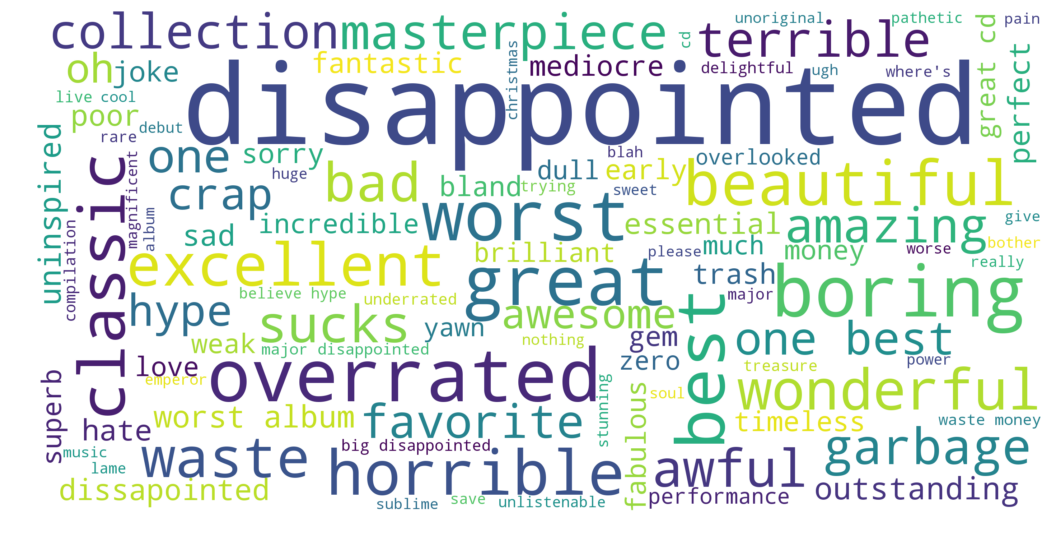

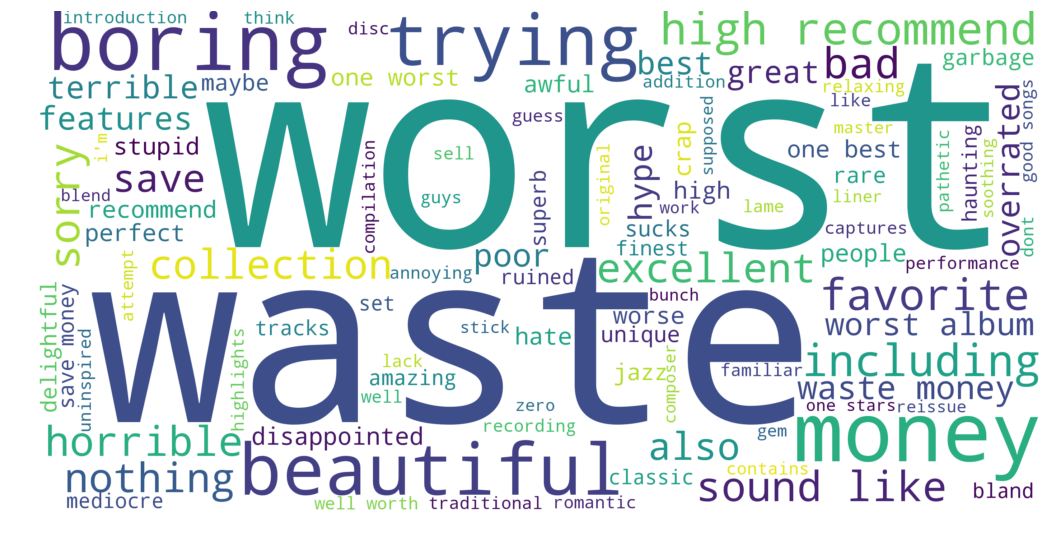

In [0]:
def word_cloud(word_to_float_dict):
  # Generate a word cloud image
  wordcloud = WordCloud(background_color="white", max_words=100,
                       width=2800, height=1400).generate_from_frequencies(word_to_float_dict)

  # Display the generated image
  plt.figure(figsize = (18, 12))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

# Head word-cloud
word_cloud({v:k for k,v in best_features_head})

# Body word-cloud
word_cloud({v:k for k,v in best_features_body})

# Results

## Plot Confusion Matrix

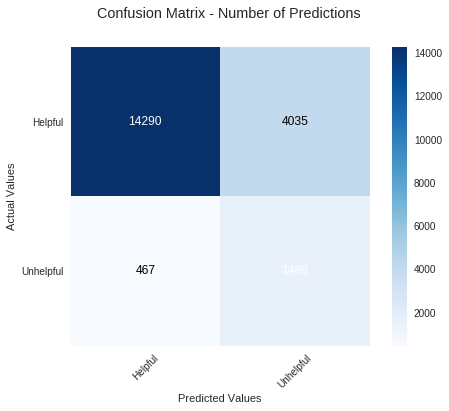

In [0]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def show_conf_matrix(cm):
  fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True)

  labels = ['Helpful', 'Unhelpful']
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.suptitle("Confusion Matrix - Number of Predictions")

  plt.xlabel("Predicted Values")
  plt.ylabel("Actual Values")
  plt.show()

###

cm = confusion_matrix(Y_test_df, y_df)
show_conf_matrix(cm)

